In [6]:
!pip install pytransform3d

In [7]:
!pip install ipympl

In [8]:
!pip install matplotlib

In [171]:
#%matplotlib ipympl

import matplotlib.pyplot as plt
from utils import *
np.random.seed(42)
np.set_printoptions(linewidth=np.inf)

### Create Groundtruth matrix

#### Define Parameters

In [172]:
# define extrinsic parameters
# -------------------------------

# rotate an angle of pi/4 along the standard Y axis
angles = [np.pi/4]
order = 'y'

# transalte by the given offset
offset = np.array([0, -8, 0])

# define intrinsic parameters
# -------------------------------

f = 2
s = 0
a = 1
cx = 0
cy = 0
img_size = (10, 10)

#### Create Extrinsic and Intrinsic Matrix

In [173]:
# create extrinsic matrix
# --------------------------

# create rotation transformation matrix
R = create_rotation_transformation_matrix(angles, order)
R_ = np.identity(4)
R_[:3, :3] = R

# create translation transformation matrix
T_ = create_translation_matrix(offset)

#unit = 10
#T_[:,-1] = T_[:,-1] * unit

E = np.linalg.inv(T_ @ R_)
E = E[:-1, :]

# create intrinsic matrix
# ---------------------------
K = compute_intrinsic_parameter_matrix(f, s, a, cx, cy)

print("Rotation matrix: \n{}\n".format(R_))
print("Translation matrix: \n{}\n".format(T_))
print("Extrinsing matrix: \n{}\n".format(E))
print("Intrinsic matrix: \n{}\n".format(K))

Rotation matrix: 
[[ 0.70710678  0.         -0.70710678  0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]]

Translation matrix: 
[[ 1.  0.  0.  0.]
 [ 0.  1.  0. -8.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]

Extrinsing matrix: 
[[ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          1.          0.          8.        ]
 [-0.70710678  0.          0.70710678  0.        ]]

Intrinsic matrix: 
[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]



#### generate random points

In [174]:
# choose the lower limit of the points such they're always beyond the image plane
np.random.seed(42)
n_points = 12
rand_points = generate_random_points(n_points, (-10, 0), (-10, 10), (f, 10))

#### Plot the setup

In [175]:
# create an image grid
xx, yy, Z = create_image_grid(f, img_size)
# convert the image grid to homogeneous coordinates
pt_h = convert_grid_to_homogeneous(xx, yy, Z, img_size)
# transform the homogeneous coordinates
pt_h_transformed = T_ @ R_ @ pt_h
# convert the transformed homogeneous coordinates back to the image grid
xxt, yyt, Zt = convert_homogeneous_to_grid(pt_h_transformed, img_size)

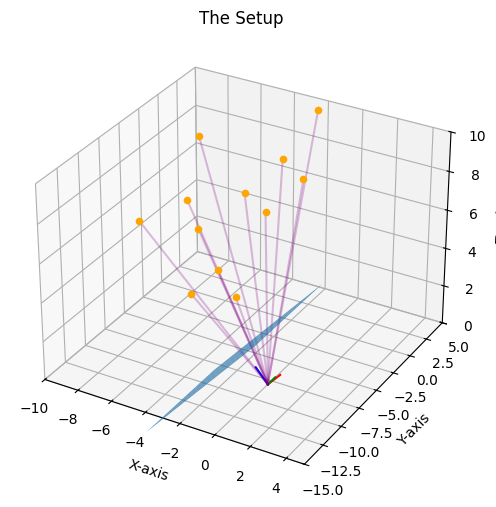

In [176]:
# define axis and figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111,projection='3d')

# set limits
ax.set(xlim=(-10, 5), ylim=(-15, 5), zlim=(0, 10))

# plot the camera in the world
ax = pr.plot_basis(ax, R, offset)
ax.plot_surface(xxt, yyt, Zt, alpha=0.75)

# plot the generated random points
c = 0
for i in range(n_points):
    point = rand_points[:, c]
    ax.scatter(*point, color="orange")
    ax.plot(*make_line(offset, point), color="purple", alpha=0.25)
    c += 1

ax.set_title("The Setup")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

#### Compute Projection of these points and form image

In [177]:
rand_points_camera = compute_coordniates_wrt_camera(rand_points, E, is_homogeneous=False)
projections = compute_image_projection(rand_points_camera, K)

#print("Coordinates in image plane (unit=pixel): \n", projections)
print("Coordinates in image plane (unit=pixel): \n", np.round(projections,2))

Coordinates in image plane (unit=pixel): 
 [[ 0.55 -0.    0.91  0.15 -0.    1.33 -0.    0.22  1.   -1.   -0.55  0.67]
 [ 0.   -0.2   2.31  0.65 -0.35 -0.94  1.59  2.83  3.3   2.47  3.34  3.77]]


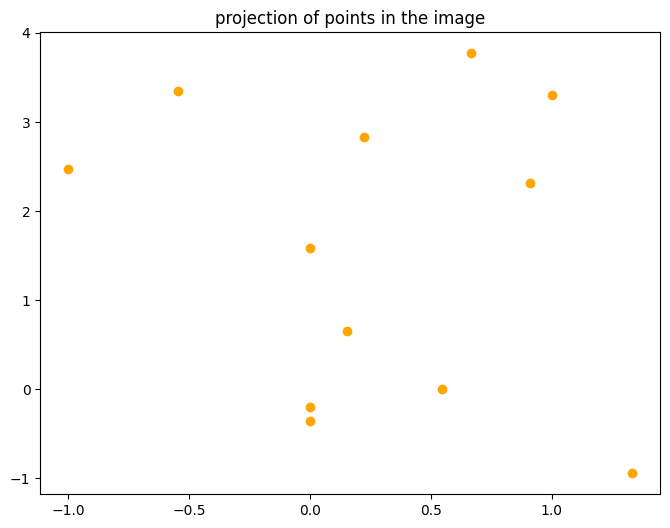

In [170]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

projs = projections.T  # shape: (n_points, 2)

for i in range(n_points):
    ax.scatter(*projs[i], color="orange")

ax.set_title("projection of points in the image")
plt.show()

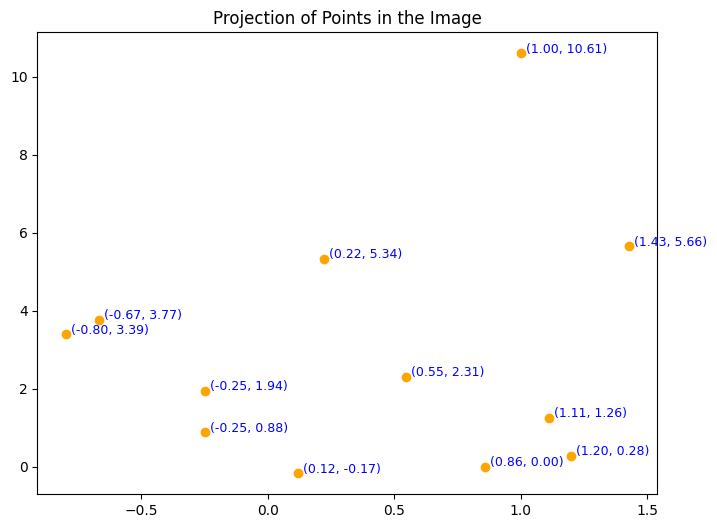

In [147]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

projs = projections.T  # shape: (n_points, 2)

for i in range(n_points):
    x, y = projs[i]
    ax.scatter(x, y, color="orange")

    # Place the text slightly offset so it’s not directly on top of the point
    ax.text(
        x + 0.02,           # small horizontal offset
        y + 0.02,           # small vertical offset
        f"({x:.2f}, {y:.2f})",  # formatted string for coordinates
        fontsize=9,
        color="blue"
    )

ax.set_title("Projection of Points in the Image")
plt.show()

### Perform Direct Linear Calibration

In [148]:
# Check units problems
print("before unit changes:")
print("xyz: \n{}".format(rand_points))
print("uv: \n{}".format(np.round(projections,2)))


print("\n\nafter unit changes:")
# Converting m to mm (just taking into account a scaling in the process)
unit = 10
rand_points *= unit
print("xyz: \n{}".format(rand_points))
print("uv: \n{}".format(np.round(projections,2)))

before unit changes:
xyz: 
[[-8 -4 -6 -2 -4 -9 -7 -2 -9 -1 -2 -1]
 [-9  9  4 -4  1 -3  4 -8  3  6 -7  7]
 [ 9  5  3  7  7  7  3  5  7  6  8  3]]
uv: 
[[ 0.12  0.22 -0.67  1.11  0.55 -0.25 -0.8   0.86 -0.25  1.43  1.2   1.  ]
 [-0.17  5.34  3.77  1.26  2.31  0.88  3.39  0.    1.94  5.66  0.28 10.61]]


after unit changes:
xyz: 
[[-80 -40 -60 -20 -40 -90 -70 -20 -90 -10 -20 -10]
 [-90  90  40 -40  10 -30  40 -80  30  60 -70  70]
 [ 90  50  30  70  70  70  30  50  70  60  80  30]]
uv: 
[[ 0.12  0.22 -0.67  1.11  0.55 -0.25 -0.8   0.86 -0.25  1.43  1.2   1.  ]
 [-0.17  5.34  3.77  1.26  2.31  0.88  3.39  0.    1.94  5.66  0.28 10.61]]


#### Create the algebraic matrix A and find m

In [149]:
# compute the algebraic matrix A
A = create_algebraic_matrix(rand_points, projections)
print('A matrix size is: {}'.format(A.shape))
print('A = \n{}'.format(np.round(A,2)))

# compute At x A
A_ = np.matmul(A.T, A)


# compute its eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(A_)
# find the eigenvector with the minimum eigenvalue
# (numpy already returns sorted eigenvectors wrt their eigenvalues)
#print("eigenvalues: {}".format(eigenvalues))

idx = np.argsort(-eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
m = eigenvectors[:, 11]

print('\n\neigenvectors matrix size is: {}'.format(eigenvectors.shape))
print('eigenvectors = \n{}'.format(np.round(eigenvectors,2)))

# reshape m back to a matrix
M = m.reshape(3, 4)
print('\n\nM matrix size is: {}'.format(M.shape))
print('M = \n{}'.format(np.round(M,2)))

Usvd, Ssvd, Vhsvd = np.linalg.svd(A, full_matrices=False)
Vhsvd = Vhsvd.T

print('\n\nsingularvectors matrix size is: {}'.format(Vhsvd.shape))
print('singularvectors = \n{}'.format(np.round(Vhsvd,2)))

m2 = Vhsvd[:,11]
M2 = m2.reshape(3, 4)
print('\n\nM matrix size is: {}'.format(M2.shape))
print('M = \n{}'.format(np.round(M2,2)))


A matrix size is: (24, 12)
A = 
[[-8.0000e+01 -9.0000e+01  9.0000e+01  1.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  9.4100e+00  1.0590e+01 -1.0590e+01 -1.2000e-01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -8.0000e+01 -9.0000e+01  9.0000e+01  1.0000e+00 -1.3310e+01 -1.4970e+01  1.4970e+01  1.7000e-01]
 [-4.0000e+01  9.0000e+01  5.0000e+01  1.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  8.8900e+00 -2.0000e+01 -1.1110e+01 -2.2000e-01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -4.0000e+01  9.0000e+01  5.0000e+01  1.0000e+00  2.1370e+02 -4.8083e+02 -2.6713e+02 -5.3400e+00]
 [-6.0000e+01  4.0000e+01  3.0000e+01  1.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -4.0000e+01  2.6670e+01  2.0000e+01  6.7000e-01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -6.0000e+01  4.0000e+01  3.0000e+01  1.0000e+00  2.2627e+02 -1.5085e+02 -1.1314e+02 -3.7700e+00]
 [-2.0000e+01 -4.0000e+01  7.0000e+01  1.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 

#### Compute predictions from the calibrated matrix M

In [150]:
predictions = compute_world2img_projection(rand_points, M, is_homogeneous=False)

print(rand_points)
print(predictions.shape)
print(np.round(predictions,2))
print(projections.shape)
print(np.round(projections,2))

[[-80 -40 -60 -20 -40 -90 -70 -20 -90 -10 -20 -10]
 [-90  90  40 -40  10 -30  40 -80  30  60 -70  70]
 [ 90  50  30  70  70  70  30  50  70  60  80  30]]
(2, 12)
[[ 0.12  0.22 -0.67  1.11  0.55 -0.25 -0.8   0.86 -0.25  1.43  1.2   1.  ]
 [-0.17  5.34  3.77  1.26  2.31  0.88  3.39 -0.    1.94  5.66  0.28 10.61]]
(2, 12)
[[ 0.12  0.22 -0.67  1.11  0.55 -0.25 -0.8   0.86 -0.25  1.43  1.2   1.  ]
 [-0.17  5.34  3.77  1.26  2.31  0.88  3.39  0.    1.94  5.66  0.28 10.61]]


#### plot predictions and the groundtruth

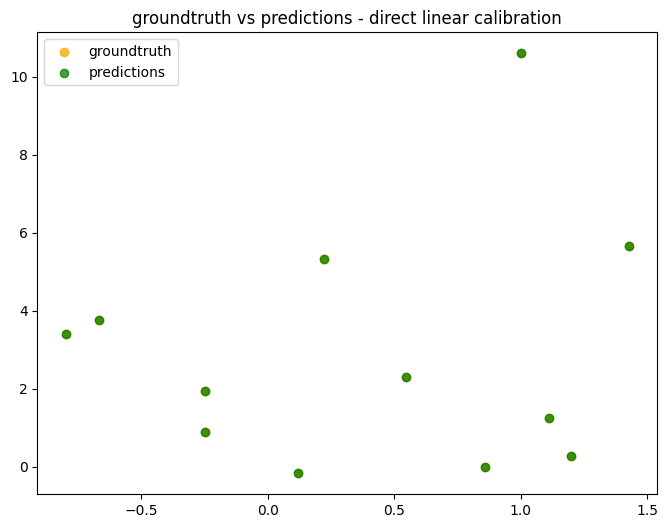

In [151]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""

    ax.scatter(projections[0,i], projections[1,i], color="orange", alpha=0.75, label=o_label)
    ax.scatter(predictions[0,i], predictions[1,i], color="green", alpha=0.75, label=g_label)

ax.set_title("groundtruth vs predictions - direct linear calibration")
ax.legend()
plt.show()

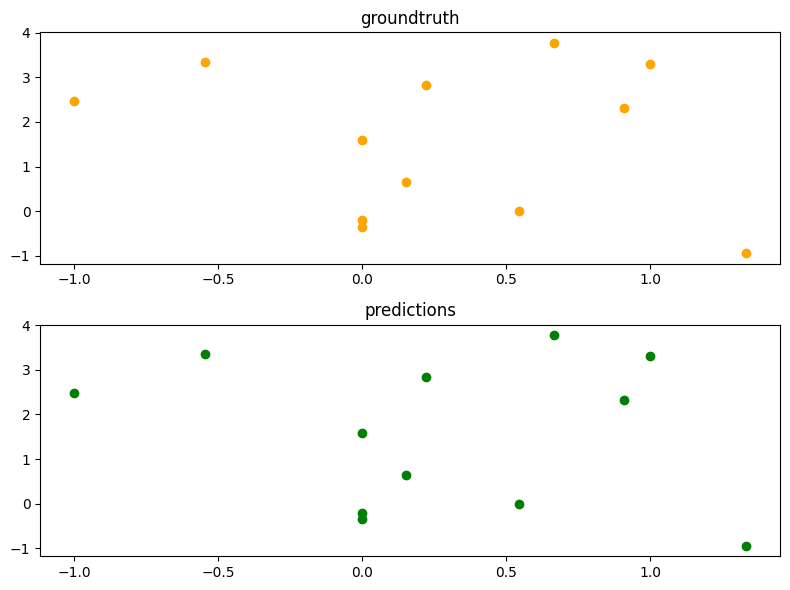

In [137]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

projs = projections.T  # shape: (n_points, 2)
preds = predictions.T  # shape: (n_points, 2)

for i in range(n_points):

    axes[0].scatter(*projs[i], color="orange", label=o_label)
    axes[1].scatter(*preds[i], color="green", label=g_label)

axes[0].set_title("groundtruth")
axes[1].set_title("predictions")

plt.tight_layout()

### Optimizing wrt Geometric Error

In [ ]:
from scipy.optimize import minimize

In [ ]:
result = minimize(geometric_error, m, args=(rand_points, projections))

In [ ]:
M_ = result.x.reshape(3, 4)

In [ ]:
predictions_v2 = compute_world2img_projection(rand_points, M_, is_homogeneous=False)

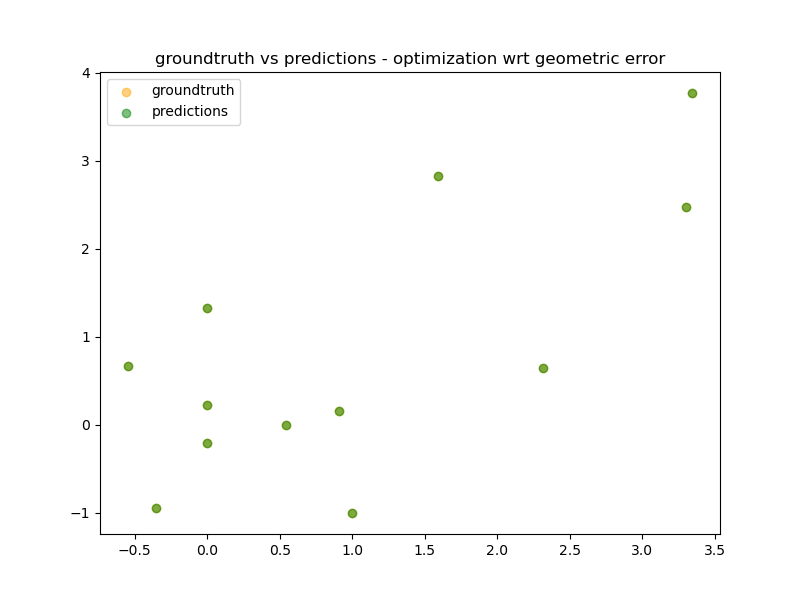

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""

    ax.scatter(*projections.reshape(-1, 2)[i], color="orange", alpha=0.5, label=o_label)
    ax.scatter(*predictions_v2.reshape(-1, 2)[i], color="green", alpha=0.5, label=g_label)

ax.set_title("groundtruth vs predictions - optimization wrt geometric error")
ax.legend()

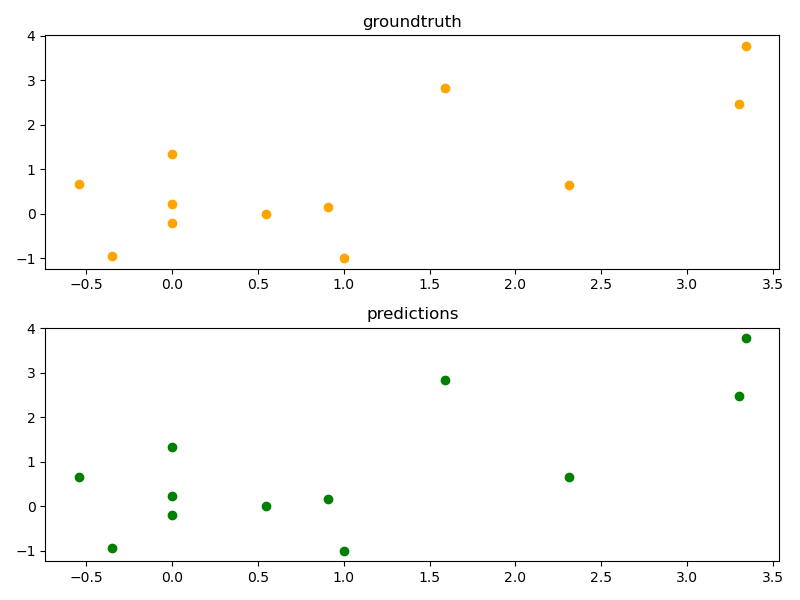

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

for i in range(n_points):

    axes[0].scatter(*projections.reshape(-1, 2)[i], color="orange", label=o_label)
    axes[1].scatter(*predictions_v2.reshape(-1, 2)[i], color="green", label=g_label)

axes[0].set_title("groundtruth")
axes[1].set_title("predictions")

plt.tight_layout()